In [1]:
#this code is inspired by https://github.com/kimiandj/gsw/blob/master/code/GSW_flows_comparison.ipynb
# it runs with python 3.10.5
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import torch
from torch import optim
import ot
import pandas as pd
from tqdm import tqdm
from IPython import display
import time
import matplotlib.pyplot as pl
import scienceplots
import os
import gradient_flows

In [2]:
# Use GPU if available, CPU otherwise
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device='cpu'
print(device)

cpu


# Sample the data

In [3]:
from sklearn import cluster, datasets
dataset_name = 'unbalanced bimodal distributions'

d = 2
n_samples_mode1 = 200 # size of the first mode
n_samples_mode2 = 70 # size of the second mode

seed = 2024
np.random.seed(seed)

#results_folder = './Results/Gradient_Flow_bimodal_distribution'
#if not os.path.isdir(results_folder):
#    os.mkdir(results_folder)

In [4]:
# the distributions are a mix of circles, blobs, moons and square
noisy_circles = datasets.make_circles(
    n_samples=n_samples_mode2*2, factor=0.8, noise=0.05, random_state=170
)

noisy_circles = noisy_circles[0][np.where(noisy_circles[1]==1)[0]]
noisy_circles[:,0] = noisy_circles[:,0] -6
noisy_circles[:,1] = noisy_circles[:,1] +2
noisy_moons = datasets.make_moons(n_samples=n_samples_mode2*2, noise=0.05, random_state=170)
noisy_moons = noisy_moons[0][np.where(noisy_moons[1]==1)[0]]
noisy_moons[:,1] = noisy_moons[:,1] -1
noisy_moons[:,0] = (noisy_moons[:,0]) * 1.5 
blobs = datasets.make_blobs(n_samples=n_samples_mode1, centers=1, random_state=170)
blobs = (blobs[0]+3)/3
blobs[:,0] =  (blobs[:,0]*2) -4
rng = np.random.RandomState(170)
no_structure = rng.rand(n_samples_mode1, 2)-2
no_structure[:,1] = no_structure[:,1]*1.5 +5
no_structure[:,0] = no_structure[:,0] + 4

source = np.concatenate((noisy_circles, no_structure)) # Define the initial distribution
source = torch.from_numpy(source).float()

X = np.concatenate((blobs, noisy_moons)) #target distribution
X = torch.from_numpy(X).float()
_, d = X.shape


In [5]:
# Number of iterations for the optimization process
nofiterations = 500

modes = 'linear'
titles = ['SW (Vanilla OT)', 'SWGG (Vanilla OT)', 'SW with PAWL', 'Sliced-PW', 'Sliced-PW (elbow)']

lear_rates = 5e-2

n_proj = 100


# Define the optimizers
Y = list()
optimizer = list()
gsw_res = list()

torch.manual_seed(2024)

for k in range(len(modes)):
    #Y.append(torch.tensor(source, dtype=torch.float, device=device, requires_grad=True))
    Y.append(source.clone().detach().requires_grad_(True))
    optimizer.append(optim.Adam([Y[k]], lr = lear_rates))
    gsw_res.append(gradient_flows.GF(ftype=modes, nofprojections=n_proj, device=device))



In [6]:
s = len(titles)


fig = pl.figure(figsize=(4*s, 8+3))
grid = pl.GridSpec(2, s, wspace=.4, hspace=0.3)

plot_fig = False #to plot the figures when running the different iterations
mem_loss = []

#nofiterations = 5
for i in range(nofiterations):
    if i%100 == 0:
        print(i)
    loss = list()
    theta = torch.ones(len(modes),d)
    
    for k in range(s):
        if k == 0:
            l = gsw_res[k].sw(X.to(device), Y[k], theta=None)
        if k == 1:
            l, theta[k] = gsw_res[k].swgg(X.to(device), Y[k].to(device), theta=None)
        if k == 2:
            l, X_swp, Y_swp = gsw_res[k].sw_partial(X.to(device), Y[k], theta=None, k = n_samples_mode2*2)
        if k == 3:
            l, theta[k], X_swggp, Y_swggp = gsw_res[k].swgg_partial(X.to(device), Y[k], theta=None, k = n_samples_mode2*2)
        if k == 4:
            l, theta[k], X_swggp_e, Y_swggp_e, elbow = gsw_res[k].swgg_partial_elbow(X.to(device), Y[k], theta=None)
        
        # Optimization step
        loss_ = l
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
         

        if plot_fig:
                temp = Y[k].detach().cpu().numpy()
                pl.subplot(grid[0, k])
                pl.cla()
                pl.scatter(X[:n_samples_mode1,0], X[:n_samples_mode1,1], c='C1')
                pl.scatter(X[n_samples_mode1: n_samples_mode2+n_samples_mode1,0], X[n_samples_mode1:n_samples_mode2+n_samples_mode1,1], c='C0')
                pl.scatter(temp[:n_samples_mode2,0], temp[:n_samples_mode2,1],c='C2')
                pl.scatter(temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,1],c='C3')
                pl.title(titles[k], fontsize=10)
                xlim1,xlim2=pl.xlim()
                ylim1,ylim2=pl.ylim()
                pl.title(titles[k], fontsize=10)

    if plot_fig:
        display.clear_output(wait=True)
        display.display(pl.gcf()) 
        time.sleep(1e-5)    

    
        #fig.savefig(results_folder + '/img%03d.png'%(i))
        for k in range(s):
            pl.cla()
        
            
            

0
100
200
300
400


<Figure size 2000x1100 with 0 Axes>

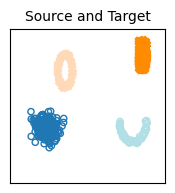

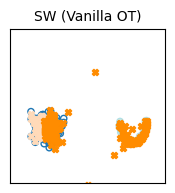

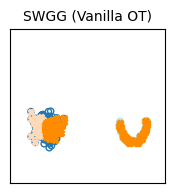

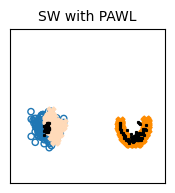

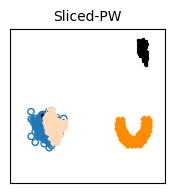

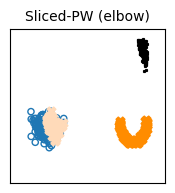

In [7]:
#pl.style.use(['science'])
#pl.rcParams['text.usetex'] = True
#pl.rcParams.update({'font.size': 22})

#titles = ['SW (Vanilla OT)', 'SWGG (Vanilla OT)', 'SW (Partial OT)', 'SWGG (Partial OT)', 'SWGG (P. OT - elbow)']

pl.figure(1, figsize=(2, 2))
temp = Y[k].detach().cpu().numpy()
if k == 1:
    Y_transp = Y_swp.detach().cpu().numpy()
elif k == 2:
    Y_transp = Y_swggp.detach().cpu().numpy()
elif k == 3:
    Y_transp = Y_swggp_e.detach().cpu().numpy()

pl.scatter(source[:n_samples_mode2,0], source[:n_samples_mode2,1],  c='peachpuff', s=20, marker = 'X')
pl.scatter(source[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], source[n_samples_mode2:n_samples_mode2+n_samples_mode1,1],  c='darkorange', s=20, marker = 'X')
pl.scatter(X[:n_samples_mode1,0], X[:n_samples_mode1,1], facecolors='none', edgecolors='C0', s=20)
pl.scatter(X[n_samples_mode1: n_samples_mode2+n_samples_mode1,0], X[n_samples_mode1:n_samples_mode2+n_samples_mode1,1], facecolors='none', edgecolors='powderblue', s=20)

#pl.scatter(source[:,0], source[:,1], marker = 'X', facecolors='none', c='tab:orange')
pl.title("Source and Target", fontsize=10)
pl.xticks([]) 
pl.yticks([]) 
pl.xlim([-12,5])
pl.ylim([-3.5,4])
#pl.savefig(results_folder + '/bimodalOriginal.pdf')
pl.show()

for k in range((len(titles))):
    pl.figure(1, figsize=(2, 2))
    temp = Y[k].detach().cpu().numpy()

    if k == 1:
        Y_transp = Y_swp.detach().cpu().numpy()
    elif k == 2:
        Y_transp = Y_swggp_e.detach().cpu().numpy()
    elif k == 3:
        Y_transp = Y_swggp_e.detach().cpu().numpy()


    pl.scatter(X[:n_samples_mode1,0], X[:n_samples_mode1,1], facecolors='none', edgecolors='C0', s=20)
    pl.scatter(X[n_samples_mode1: n_samples_mode2+n_samples_mode1,0], X[n_samples_mode1:n_samples_mode2+n_samples_mode1,1], facecolors='none', edgecolors='powderblue', s=20)
    if k == 2:
        pl.scatter(Y_transp[:n_samples_mode2,0], Y_transp[:n_samples_mode2,1],  c='peachpuff', s=40, marker = 'X')
        pl.scatter(Y_transp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], Y_transp[n_samples_mode2:n_samples_mode2+n_samples_mode1,1], color='darkorange', s=40, marker = 'X')
        pl.scatter(temp[:n_samples_mode2,0], temp[:n_samples_mode2,1],  c='black', s=2, marker = 'X')
        pl.scatter(temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], temp[n_samples_mode2:n_samples_mode2+n_samples_mode1,1], color='black', s=2, marker = 'X')
    elif k >2:
        pl.scatter(temp[:n_samples_mode2,0], temp[:n_samples_mode2,1],  c='black', s=2, marker = 'X')
        pl.scatter(temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], temp[n_samples_mode2:n_samples_mode2+n_samples_mode1,1], color='black', s=2, marker = 'X')
        pl.scatter(Y_transp[:n_samples_mode2,0], Y_transp[:n_samples_mode2,1],  c='peachpuff', s=40, marker = 'X')
        pl.scatter(Y_transp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], Y_transp[n_samples_mode2:n_samples_mode2+n_samples_mode1,1], color='darkorange', s=40, marker = 'X')
    else:
        pl.scatter(temp[:n_samples_mode2,0], temp[:n_samples_mode2,1],  c='peachpuff', s=20, marker = 'X')
        pl.scatter(temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], temp[n_samples_mode2:n_samples_mode2+n_samples_mode1,1],  c='darkorange', s=20, marker = 'X')
    

    pl.title(titles[k], fontsize=10)
    pl.xticks([]) 
    pl.yticks([]) 
    pl.xlim([-12,5])
    pl.ylim([-3.5,4])
    #pl.savefig(results_folder + '/bimodal%03d.pdf'%(k))
    pl.show()